<center><h1>FinalProject</h1></center>

Name: Chenyu<br>
Github Username: IrisQiuu<br>


## 1. Transfer Learning for Video Classification

Import packages

In [1]:
import os
import cv2
import random 
import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, classification_report
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

#ref: https://www.tensorflow.org/guide/keras/transfer_learning

### (a) In this problem, we are trying to build a classifier that distinguishes videos of 5 different activities

### (b) Video Classification

### (c) Moving Averages over Predictions for Video Classification

### (d) Data Exploration and Pre-processing

#### i. Images in each class are given in separate folders in the folder Sport Images. We have several hundreds of images for five classes of sport activities, namely baseball, basketball, fencing, tennis, and volleyball. ii. Randomly select 0.7ni images from each folder as your training set, 0.15ni as validation set, and the rest as your test set, where ni is the number of images in folder i and x is the ceiling of x. iii. In order for all the images to have the same size, zero-pad or resize the images in your dataset. This can be done using various tools, including OpenCV.

In [2]:
#convert images into .jpg format
input_dir = '../data/Sport Images'
output_dir = '../data/Sport Images_convert'

datalist = sorted(os.listdir(input_dir))
datalist = [element for element in datalist if element not in ('Image URLs','.DS_Store')]

#category matching: 0='baseball', 1='basketball',  2='fencing', 3='tennis', 4='volleyball'
for i in range(len(datalist)):
    output_folder = os.path.join(output_dir, str(i))
    os.makedirs(output_folder, exist_ok=True)
    
    for f in os.listdir(os.path.join(input_dir, datalist[i])):
        if f.endswith('.jpg') or f.endswith('.jpeg') or f.endswith('.JPG') or f.endswith('.png') or f.endswith('.PNG') or f.endswith('.webp') or f.endswith('.gif'):
            #save as jpg in output folder
            with Image.open(os.path.join(input_dir, datalist[i], f)) as im:
                im.convert('RGB').save(os.path.join(output_folder, os.path.splitext(f)[0] + '.jpg'))

#check image types
data_dir = '../data/Sport Images_convert'

for folder in os.listdir(data_dir):
    files = glob.glob(os.path.join(data_dir, folder, '*'))
    image_files = [f for f in files]

    img_type=[]
    if len(image_files) > 0:
        print(f"Folder {folder} contains {len(image_files)} images of types:")
        for f in image_files:
            img_type.append(f.split('.')[-1])
        counts = Counter(img_type)
        for element, count in counts.items():
            print(f"{element}: {count}")
    else:
        print(f"Folder {folder} does not contain any image files.")

Folder 0 contains 735 images of types:
jpg: 735
Folder 1 contains 492 images of types:
jpg: 492
Folder 4 contains 704 images of types:
jpg: 704
Folder 3 contains 715 images of types:
jpg: 715
Folder 2 contains 634 images of types:
jpg: 634


In [3]:
#set path to save training/validation/test datasets
split_dir = '../data/Split Images'

#set up the split parameter and image sizes
train_pct = 0.7
val_pct = 0.15
img_size = (224, 224)

datalist = os.listdir(data_dir)

#run loop
for folder in datalist:
    train_dir = os.path.join(split_dir, 'train', folder)
    val_dir = os.path.join(split_dir, 'val', folder)
    test_dir = os.path.join(split_dir, 'test', folder)
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)
    files = os.listdir(os.path.join(data_dir, folder))
    image_files = [f for f in files if f.endswith('.jpg')]
    random.shuffle(image_files)

    #split image files
    num_images = len(image_files)
    num_train = int(num_images * train_pct)
    num_val = int(num_images * val_pct)
    num_test = num_images - num_train - num_val
    train_files = image_files[:num_train]
    val_files = image_files[num_train:num_train+num_val]
    test_files = image_files[num_train+num_val:]

    #resize
    for f in train_files:
        src = os.path.join(data_dir, folder, f)
        dst = os.path.join(train_dir, f)
        img = cv2.imread(src)
        img_resized = cv2.resize(img, img_size)
        cv2.imwrite(dst, img_resized)
    for f in val_files:
        src = os.path.join(data_dir, folder, f)
        dst = os.path.join(val_dir, f)
        img = cv2.imread(src)
        img_resized = cv2.resize(img, img_size)
        cv2.imwrite(dst, img_resized)
    for f in test_files:
        src = os.path.join(data_dir, folder, f)
        dst = os.path.join(test_dir, f)
        img = cv2.imread(src)
        img_resized = cv2.resize(img, img_size)
        cv2.imwrite(dst, img_resized)

### (e) Transfer Learning for Image Classification

    (1) ResNet50 Model 

In [4]:
#use OpenCV to perform image augmentation
#tested on individual augmentation method, as well as different combinations
train_datagen_res = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')

test_datagen_res = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

#generate data
batch_size = 35  
train_generator = train_datagen_res.flow_from_directory(
        '../data/Split Images/train',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

validation_generator = test_datagen_res.flow_from_directory(
        '../data/Split Images/val',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

test_generator = test_datagen_res.flow_from_directory(
        '../data/Split Images/test',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 2293 images belonging to 5 classes.
Found 490 images belonging to 5 classes.
Found 497 images belonging to 5 classes.


In [5]:
n_epochs = 50
#load pre-trained ResNet50 model 
resnet = tf.keras.applications.ResNet50(weights='imagenet', include_top=True, input_shape=(224, 224, 3))

#build model
for layer in resnet.layers[:-1]:
    layer.trainable = False

model_out = resnet.get_layer('avg_pool').output
model_out = Flatten()(model_out)
model_out = Activation('relu')(model_out)
model_out = Dropout(0.2)(model_out)
model_out = BatchNormalization()(model_out)
predictions = Dense(5, activation='softmax')(model_out)
model = Model(inputs=resnet.input, outputs=predictions)

#for i, layer in enumerate(model.layers):
#    print(i, layer.name, '', layer.trainable)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision()])#,tf.keras.metrics.Precision(),optimizer=Adam(learning_rate=0.001)

#fit model
early_stopping = EarlyStopping(monitor='val_loss', patience=20)#add patience to avoid overfitting
checkpoint_name = '../data/model/resnet_bestw.h5'
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', save_best_only=True, mode='min', verbose=1)

resnet_out = model.fit(
        train_generator,
        epochs=n_epochs,
        validation_data=validation_generator,
        callbacks=[early_stopping, checkpoint])

Epoch 1/50
66/66 [==============================] - ETA: 0s - loss: 2.0762 - categorical_accuracy: 0.1993 - precision: 0.2066
Epoch 1: val_loss improved from inf to 1.46787, saving model to ../data/model/resnet_bestw.h5
66/66 [==============================] - 92s 1s/step - loss: 2.0762 - categorical_accuracy: 0.1993 - precision: 0.2066 - val_loss: 1.4679 - val_categorical_accuracy: 0.3653 - val_precision: 0.4386
Epoch 2/50
66/66 [==============================] - ETA: 0s - loss: 1.8924 - categorical_accuracy: 0.2024 - precision: 0.2210
Epoch 2: val_loss improved from 1.46787 to 1.41463, saving model to ../data/model/resnet_bestw.h5
66/66 [==============================] - 87s 1s/step - loss: 1.8924 - categorical_accuracy: 0.2024 - precision: 0.2210 - val_loss: 1.4146 - val_categorical_accuracy: 0.3959 - val_precision: 0.6667
Epoch 3/50
66/66 [==============================] - ETA: 0s - loss: 1.7976 - categorical_accuracy: 0.2159 - precision: 0.2679
Epoch 3: val_loss did not improve fr

Epoch 44/50
66/66 [==============================] - ETA: 0s - loss: 1.6253 - categorical_accuracy: 0.2386 - precision: 0.6667
Epoch 44: val_loss did not improve from 1.16224
66/66 [==============================] - 88s 1s/step - loss: 1.6253 - categorical_accuracy: 0.2386 - precision: 0.6667 - val_loss: 1.3422 - val_categorical_accuracy: 0.5061 - val_precision: 1.0000


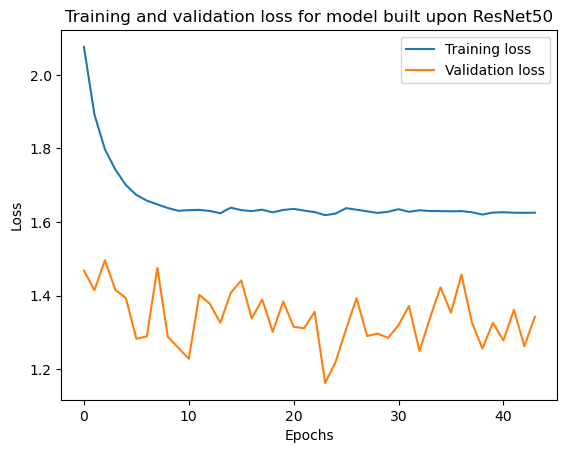

66/66 [==============================] - 73s 1s/step

=========Train=========
Confusion Matrix:
 [[134  27  56 173 124]
 [ 23 165   9  41 106]
 [ 12  10 299  15 107]
 [ 15   5  28 430  22]
 [ 12  39  16  25 400]]
Precision:
 0.6456194519475905
Recall:
 0.6227649367640645
Accuracy:
 0.6227649367640645
F1 score:
 0.5998800485846275
15/15 [==============================] - 16s 1s/step

=========Test=========
Confusion Matrix:
 [[ 26   5   8  42  30]
 [  4  45   3   5  18]
 [  4   2  68   2  20]
 [  1   2   2 100   3]
 [  4  15   1   6  81]]
Precision:
 0.6624143979331305
Recall:
 0.6438631790744467
Accuracy:
 0.6438631790744467
F1 score:
 0.619233869416343


In [6]:
#plot
plt.plot(resnet_out.history['loss'], label='Training loss')
plt.plot(resnet_out.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss for model built upon ResNet50')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#get results
model.load_weights(checkpoint_name)
model.save('../data/model/resnet_model.h5')

y_pred_train = np.argmax(model.predict(train_generator), axis=1)
y_train = train_generator.classes
print('\n=========Train=========')
print('Confusion Matrix:\n', confusion_matrix(y_train, y_pred_train))
print('Precision:\n', precision_score(y_train, y_pred_train, average='weighted'))
print('Recall:\n', recall_score(y_train, y_pred_train, average='weighted'))
print('Accuracy:\n', accuracy_score(y_train, y_pred_train))
print('F1 score:\n', f1_score(y_train, y_pred_train, average='weighted'))

y_pred_test = np.argmax(model.predict(test_generator), axis=1)
y_test = test_generator.classes
print('\n=========Test=========')
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred_test))
print('Precision:\n', precision_score(y_test, y_pred_test, average='weighted'))
print('Recall:\n', recall_score(y_test, y_pred_test, average='weighted'))
print('Accuracy:\n', accuracy_score(y_test, y_pred_test))
print('F1 score:\n', f1_score(y_test, y_pred_test, average='weighted'))

    (2) EfficientNetB0 Model 

In [7]:
#image augmentation
#tested on individual augmentation method, as well as different combinations
train_datagen = ImageDataGenerator(preprocessing_function=lambda x: cv2.cvtColor(x, cv2.COLOR_BGR2RGB),
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(preprocessing_function=lambda x: cv2.cvtColor(x, cv2.COLOR_BGR2RGB))

#generate data
batch_size = 35  
train_generator = train_datagen.flow_from_directory(
        '../data/Split Images/train',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

validation_generator = test_datagen.flow_from_directory(
        '../data/Split Images/val',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

test_generator = test_datagen.flow_from_directory(
        '../data/Split Images/test',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 2293 images belonging to 5 classes.
Found 490 images belonging to 5 classes.
Found 497 images belonging to 5 classes.


In [8]:
#load pre-trained model 
effnet = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=True, input_shape=(224, 224, 3))

#build model
for layer in effnet.layers[:-1]:
    layer.trainable = False

model_out = effnet.get_layer('top_dropout').output
model_out = Flatten()(model_out)
model_out = Activation('relu')(model_out)
model_out = Dropout(0.2)(model_out)
model_out = BatchNormalization()(model_out)
predictions = Dense(5, activation='softmax')(model_out)
model = Model(inputs=effnet.input, outputs=predictions)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision()])

#fit model
early_stopping = EarlyStopping(monitor='val_loss', patience=20)
checkpoint_name = '../data/model/effnet_bestw.h5'
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', save_best_only=True, mode='min', verbose=1)

effnet_out = model.fit(
        train_generator,
        epochs=n_epochs,
        validation_data=validation_generator,
        callbacks=[early_stopping, checkpoint])


Epoch 1/50
66/66 [==============================] - ETA: 0s - loss: 2.0911 - categorical_accuracy: 0.2054 - precision_1: 0.2205
Epoch 1: val_loss improved from inf to 1.54018, saving model to ../data/model/effnet_bestw.h5
66/66 [==============================] - 64s 885ms/step - loss: 2.0911 - categorical_accuracy: 0.2054 - precision_1: 0.2205 - val_loss: 1.5402 - val_categorical_accuracy: 0.3245 - val_precision_1: 0.0000e+00
Epoch 2/50
66/66 [==============================] - ETA: 0s - loss: 1.8884 - categorical_accuracy: 0.1993 - precision_1: 0.1937
Epoch 2: val_loss did not improve from 1.54018
66/66 [==============================] - 57s 858ms/step - loss: 1.8884 - categorical_accuracy: 0.1993 - precision_1: 0.1937 - val_loss: 1.5476 - val_categorical_accuracy: 0.3143 - val_precision_1: 0.0000e+00
Epoch 3/50
66/66 [==============================] - ETA: 0s - loss: 1.7768 - categorical_accuracy: 0.2150 - precision_1: 0.2079
Epoch 3: val_loss improved from 1.54018 to 1.48385, saving 

Epoch 22/50
66/66 [==============================] - ETA: 0s - loss: 1.6189 - categorical_accuracy: 0.2355 - precision_1: 0.0000e+00
Epoch 22: val_loss did not improve from 1.32722
66/66 [==============================] - 56s 853ms/step - loss: 1.6189 - categorical_accuracy: 0.2355 - precision_1: 0.0000e+00 - val_loss: 1.4087 - val_categorical_accuracy: 0.6510 - val_precision_1: 0.0000e+00
Epoch 23/50
66/66 [==============================] - ETA: 0s - loss: 1.6194 - categorical_accuracy: 0.2460 - precision_1: 1.0000
Epoch 23: val_loss did not improve from 1.32722
66/66 [==============================] - 57s 858ms/step - loss: 1.6194 - categorical_accuracy: 0.2460 - precision_1: 1.0000 - val_loss: 1.4483 - val_categorical_accuracy: 0.5612 - val_precision_1: 0.0000e+00
Epoch 24/50
66/66 [==============================] - ETA: 0s - loss: 1.6200 - categorical_accuracy: 0.2368 - precision_1: 1.0000
Epoch 24: val_loss did not improve from 1.32722
66/66 [==============================] - 57s 

Epoch 43/50
66/66 [==============================] - ETA: 0s - loss: 1.6146 - categorical_accuracy: 0.2364 - precision_1: 1.0000
Epoch 43: val_loss did not improve from 1.31894
66/66 [==============================] - 57s 858ms/step - loss: 1.6146 - categorical_accuracy: 0.2364 - precision_1: 1.0000 - val_loss: 1.4636 - val_categorical_accuracy: 0.5449 - val_precision_1: 0.0000e+00
Epoch 44/50
66/66 [==============================] - ETA: 0s - loss: 1.6143 - categorical_accuracy: 0.2403 - precision_1: 0.0000e+00
Epoch 44: val_loss did not improve from 1.31894
66/66 [==============================] - 57s 859ms/step - loss: 1.6143 - categorical_accuracy: 0.2403 - precision_1: 0.0000e+00 - val_loss: 1.4276 - val_categorical_accuracy: 0.5204 - val_precision_1: 0.0000e+00
Epoch 45/50
66/66 [==============================] - ETA: 0s - loss: 1.6139 - categorical_accuracy: 0.2460 - precision_1: 1.0000
Epoch 45: val_loss did not improve from 1.31894
66/66 [==============================] - 57s 

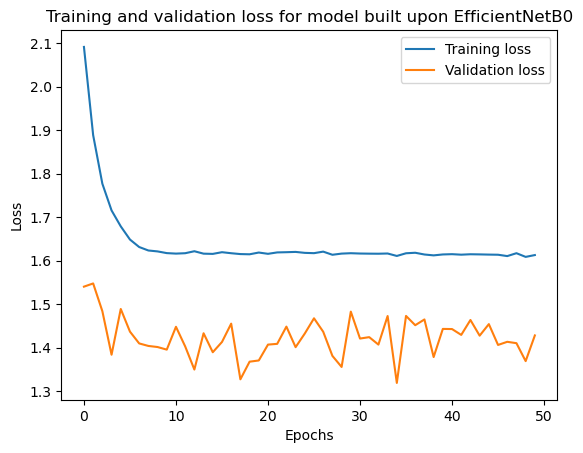

66/66 [==============================] - 48s 712ms/step

=========Train=========
Confusion Matrix:
 [[251   9  50 176  28]
 [ 19 230   9  42  44]
 [ 57   5 321  28  32]
 [ 65   5  47 346  37]
 [ 56  27  29  55 325]]
Precision:
 0.652862634547536
Recall:
 0.6423898822503271
Accuracy:
 0.6423898822503271
F1 score:
 0.6433847845259012
15/15 [==============================] - 10s 674ms/step

=========Test=========
Confusion Matrix:
 [[66  0  6 21 18]
 [ 1 64  1  0  9]
 [17  0 73  3  3]
 [10  2 14 72 10]
 [ 9  7  2  3 86]]
Precision:
 0.7272773417041607
Recall:
 0.7263581488933601
Accuracy:
 0.7263581488933601
F1 score:
 0.7252509332608029


In [9]:
#plot
plt.plot(effnet_out.history['loss'], label='Training loss')
plt.plot(effnet_out.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss for model built upon EfficientNetB0')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#get results
model.load_weights(checkpoint_name)
model.save('../data/model/effnet_model.h5')

y_pred_train = np.argmax(model.predict(train_generator), axis=1)
y_train = train_generator.classes
print('\n=========Train=========')
print('Confusion Matrix:\n', confusion_matrix(y_train, y_pred_train))
print('Precision:\n', precision_score(y_train, y_pred_train, average='weighted'))
print('Recall:\n', recall_score(y_train, y_pred_train, average='weighted'))
print('Accuracy:\n', accuracy_score(y_train, y_pred_train))
print('F1 score:\n', f1_score(y_train, y_pred_train, average='weighted'))


y_pred_test = np.argmax(model.predict(test_generator), axis=1)
y_test = test_generator.classes
print('\n=========Test=========')
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred_test))
print('Precision:\n', precision_score(y_test, y_pred_test, average='weighted'))
print('Recall:\n', recall_score(y_test, y_pred_test, average='weighted'))
print('Accuracy:\n', accuracy_score(y_test, y_pred_test))
print('F1 score:\n', f1_score(y_test, y_pred_test, average='weighted'))


    (3) VGG16 Model

In [10]:
#load pre-trained model 
vgg = tf.keras.applications.VGG16(weights='imagenet', include_top=True, input_shape=(224, 224, 3))

#build model
for layer in vgg.layers[:-2]:
    layer.trainable = False

model_out = vgg.get_layer('fc2').output
model_out = Flatten()(model_out)
model_out = Activation('relu')(model_out)
model_out = Dropout(0.2)(model_out)
model_out = BatchNormalization()(model_out)
predictions = Dense(5, activation='softmax')(model_out)

model = Model(inputs=vgg.input, outputs=predictions)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision()])

#fit model
early_stopping = EarlyStopping(monitor='val_loss', patience=20)
checkpoint_name = '../data/model/vgg_bestw.h5'
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', save_best_only=True, mode='min', verbose=1)

vgg_out = model.fit(
        train_generator,
        epochs=n_epochs,
        validation_data=validation_generator,
        callbacks=[early_stopping, checkpoint])

Epoch 1/50
66/66 [==============================] - ETA: 0s - loss: 2.6290 - categorical_accuracy: 0.1984 - precision_2: 0.1977
Epoch 1: val_loss improved from inf to 2.17944, saving model to ../data/model/vgg_bestw.h5
66/66 [==============================] - 174s 3s/step - loss: 2.6290 - categorical_accuracy: 0.1984 - precision_2: 0.1977 - val_loss: 2.1794 - val_categorical_accuracy: 0.2204 - val_precision_2: 0.2368
Epoch 2/50
66/66 [==============================] - ETA: 0s - loss: 1.7950 - categorical_accuracy: 0.2176 - precision_2: 0.2638
Epoch 2: val_loss improved from 2.17944 to 1.79057, saving model to ../data/model/vgg_bestw.h5
66/66 [==============================] - 182s 3s/step - loss: 1.7950 - categorical_accuracy: 0.2176 - precision_2: 0.2638 - val_loss: 1.7906 - val_categorical_accuracy: 0.3388 - val_precision_2: 0.4550
Epoch 3/50
66/66 [==============================] - ETA: 0s - loss: 1.7132 - categorical_accuracy: 0.2067 - precision_2: 0.2235
Epoch 3: val_loss improved

66/66 [==============================] - 181s 3s/step - loss: 1.6103 - categorical_accuracy: 0.2468 - precision_2: 0.8462 - val_loss: 1.3380 - val_categorical_accuracy: 0.5408 - val_precision_2: 0.8947
Epoch 44/50
66/66 [==============================] - ETA: 0s - loss: 1.6107 - categorical_accuracy: 0.2425 - precision_2: 0.9091
Epoch 44: val_loss did not improve from 1.18331
66/66 [==============================] - 182s 3s/step - loss: 1.6107 - categorical_accuracy: 0.2425 - precision_2: 0.9091 - val_loss: 1.3233 - val_categorical_accuracy: 0.5898 - val_precision_2: 0.9091
Epoch 45/50
66/66 [==============================] - ETA: 0s - loss: 1.6105 - categorical_accuracy: 0.2464 - precision_2: 0.8000
Epoch 45: val_loss did not improve from 1.18331
66/66 [==============================] - 183s 3s/step - loss: 1.6105 - categorical_accuracy: 0.2464 - precision_2: 0.8000 - val_loss: 1.2965 - val_categorical_accuracy: 0.6347 - val_precision_2: 0.9200
Epoch 46/50
66/66 [=====================

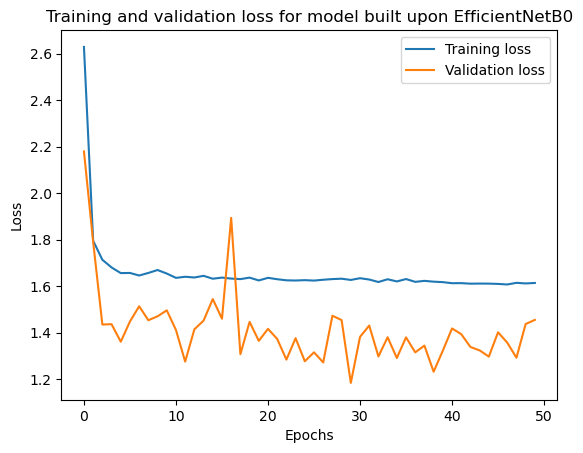

66/66 [==============================] - 149s 2s/step

=========Train=========
Confusion Matrix:
 [[287   8  24 103  92]
 [  1 227  10  49  57]
 [ 60   2 249  29 103]
 [ 67  10  12 378  33]
 [ 33  53   9  12 385]]
Precision:
 0.6830096919382932
Recall:
 0.6655037069341474
Accuracy:
 0.6655037069341474
F1 score:
 0.6644126261011246
15/15 [==============================] - 31s 2s/step

=========Test=========
Confusion Matrix:
 [[79  1  0 24  7]
 [ 1 64  0  6  4]
 [ 8  0 66 11 11]
 [14  2  3 85  4]
 [13 19  0  4 71]]
Precision:
 0.7501553050345833
Recall:
 0.7344064386317908
Accuracy:
 0.7344064386317908
F1 score:
 0.7357190108727786


In [11]:
#plot
plt.plot(vgg_out.history['loss'], label='Training loss')
plt.plot(vgg_out.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss for model built upon EfficientNetB0')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#get results
model.load_weights(checkpoint_name)
model.save('../data/model/vgg_model.h5')

#model.set_weights(model.get_weights())
y_pred_train = np.argmax(model.predict(train_generator), axis=1)
y_train = train_generator.classes
print('\n=========Train=========')
print('Confusion Matrix:\n', confusion_matrix(y_train, y_pred_train))
print('Precision:\n', precision_score(y_train, y_pred_train, average='weighted'))
print('Recall:\n', recall_score(y_train, y_pred_train, average='weighted'))
print('Accuracy:\n', accuracy_score(y_train, y_pred_train))
print('F1 score:\n', f1_score(y_train, y_pred_train, average='weighted'))


y_pred_test = np.argmax(model.predict(test_generator), axis=1)
y_test = test_generator.classes
print('\n=========Test=========')
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred_test))
print('Precision:\n', precision_score(y_test, y_pred_test, average='weighted'))
print('Recall:\n', recall_score(y_test, y_pred_test, average='weighted'))
print('Accuracy:\n', accuracy_score(y_test, y_pred_test))
print('F1 score:\n', f1_score(y_test, y_pred_test, average='weighted'))


Multiple strategies had been used to increase model performance, including modifying ImageDataGenerator, increasing batch size, increasing patience number for early stopping, adjustment on learning rate, and etc. Unfortunately, the model can only correctly predict 70% of the data points in test dataset. If time allows, we should use grid search or other tools for parameter tuning.

### (f) Video Classification Using Moving Averages

    (1) Retrain Model

In [12]:
#use all data points to fit model
data_generator_res = train_datagen_res.flow_from_directory(
        '../data/Sport Images_convert',
        target_size=(224, 224),
        batch_size=35,#larger batch size
        class_mode='categorical',
        shuffle=False)

data_generator = train_datagen.flow_from_directory(
        '../data/Sport Images_convert',
        target_size=(224, 224),
        batch_size=35,#larger batch size
        class_mode='categorical',
        shuffle=False)

Found 3280 images belonging to 5 classes.
Found 3280 images belonging to 5 classes.


In [16]:
#load the model trained from ResNet50, retrain model starting with a lower learning rate
resnet_model = load_model('../data/model/resnet_model.h5')
resnet_model.compile(optimizer=Adam(1e-5),loss='categorical_crossentropy', metrics=[tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision()])# Very low learning rate
resnet_final_out = resnet_model.fit(data_generator_res, epochs=24, verbose=0)

#load the model trained from EfficientNetB0, retrain model starting with a lower learning rate
effnet_model = load_model('../data/model/effnet_model.h5')
effnet_model.compile(optimizer=Adam(1e-5),loss='categorical_crossentropy', metrics=[tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision()])# Very low learning rate
effnet_final_out = effnet_model.fit(data_generator, epochs=35, verbose=0)

#load the model trained from VGG16, retrain model starting with a lower learning rate
vgg_model = load_model('../data/model/vgg_model.h5')
vgg_model.compile(optimizer=Adam(1e-5),loss='categorical_crossentropy', metrics=[tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision()])# Very low learning rate
vgg_final_out = vgg_model.fit(data_generator, epochs=30, verbose=0)

#resnet_model.save('../data/model/resnet_model_final.h5')
#effnet_model.save('../data/model/effnet_model_final.h5')
#vgg_model.save('../data/model/vgg_model_final.h5')

    (2) Video classification

In [18]:
#model = load_model('../data/model/resnet_model.h5') for testing
video_folder = '../data/Sport Videos'
num_frames = 100 #this is L
classes = os.listdir(video_folder)
classes = [element for element in classes if element not in ('.DS_Store')]

#print(classes)#['TennisSwing', 'BaseballPitch', 'Basketball', 'VolleyballSpiking', 'Fencing']
#category matching: 0='baseball', 1='basketball', 2='volleyball', 3='fencing', 4='tennis'
labels = [4, 0, 1, 2, 3]

resnet_pred_labels = []
effnet_pred_labels = []
vgg_pred_labels = []
actual_labels = []
for class_idx, class_name in enumerate(classes):
    video_folder = os.path.join('../data/Sport Videos', class_name)
    for video_file in os.listdir(video_folder):
        video_path = os.path.join(video_folder, video_file)
        
        #load and preprocess the video frames
        frames = []
        cap = cv2.VideoCapture(video_path)
        while len(frames) < num_frames:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.resize(frame, (224, 224))
            frames.append(frame)
        cap.release()

        #prediction for the frames
        resnet_prob_vectors = resnet_model.predict(np.array(frames))
        effnet_prob_vectors = effnet_model.predict(np.array(frames))
        vgg_prob_vectors = vgg_model.predict(np.array(frames))
        resnet_prob_mean = np.mean(resnet_prob_vectors, axis=0)
        effnet_prob_mean = np.mean(effnet_prob_vectors, axis=0)
        vgg_prob_mean = np.mean(vgg_prob_vectors, axis=0)

        #assign to the class with the max prob
        resnet_pred_labels.append(np.argmax(resnet_prob_mean))
        effnet_pred_labels.append(np.argmax(effnet_prob_mean))
        vgg_pred_labels.append(np.argmax(vgg_prob_mean))
        
        actual_labels.append(labels[class_idx])

3/3 [==============================] - 6s 2s/step


4/4 [==============================] - 5s 1s/step


4/4 [==============================] - 9s 2s/step


4/4 [==============================] - 27s 7s/step


3/3 [==============================] - 3s 798ms/step


4/4 [==============================] - 21s 5s/step


4/4 [==============================] - 20s 5s/step


In [21]:
import warnings
warnings.filterwarnings('ignore')
print('\n=========Model built upon ResNet50=========')
print('Confusion Matrix:\n', confusion_matrix(actual_labels, resnet_pred_labels))
print('Precision:\n', precision_score(actual_labels, resnet_pred_labels, average='weighted'))
print('Recall:\n', recall_score(actual_labels, resnet_pred_labels, average='weighted'))
print('Accuracy:\n', accuracy_score(actual_labels, resnet_pred_labels))
print('F1 score:\n', f1_score(actual_labels, resnet_pred_labels, average='weighted'))
print('Classification report:', classification_report(actual_labels, resnet_pred_labels, target_names=classes))

print('\n=========model built upon EfficientNetB0=========')
print('Confusion Matrix:\n', confusion_matrix(actual_labels, effnet_pred_labels))
print('Precision:\n', precision_score(actual_labels, effnet_pred_labels, average='weighted'))
print('Recall:\n', recall_score(actual_labels, effnet_pred_labels, average='weighted'))
print('Accuracy:\n', accuracy_score(actual_labels, effnet_pred_labels))
print('F1 score:\n', f1_score(actual_labels, effnet_pred_labels, average='weighted'))
print('Classification report:', classification_report(actual_labels, effnet_pred_labels, target_names=classes))

print('\n=========Model built upon VGG16=========')
print('Confusion Matrix:\n', confusion_matrix(actual_labels, vgg_pred_labels))
print('Precision:\n', precision_score(actual_labels, vgg_pred_labels, average='weighted'))
print('Recall:\n', recall_score(actual_labels, vgg_pred_labels, average='weighted'))
print('Accuracy:\n', accuracy_score(actual_labels, vgg_pred_labels))
print('F1 score:\n', f1_score(actual_labels, vgg_pred_labels, average='weighted'))
print('Classification report:', classification_report(actual_labels, vgg_pred_labels, target_names=classes))



=========Model built upon ResNet50=========
Confusion Matrix:
 [[68  1 55 24  2]
 [52  0 55 15 15]
 [26  0 68 11 11]
 [15  0 90  2  4]
 [81  0 20 66  0]]
Precision:
 0.10487372268967811
Recall:
 0.2026431718061674
Accuracy:
 0.2026431718061674
F1 score:
 0.13660673407613305
Classification report:                    precision    recall  f1-score   support

      TennisSwing       0.28      0.45      0.35       150
    BaseballPitch       0.00      0.00      0.00       137
       Basketball       0.24      0.59      0.34       116
VolleyballSpiking       0.02      0.02      0.02       111
          Fencing       0.00      0.00      0.00       167

         accuracy                           0.20       681
        macro avg       0.11      0.21      0.14       681
     weighted avg       0.10      0.20      0.14       681


=========model built upon EfficientNetB0=========
Confusion Matrix:
 [[ 39   0   3  71  37]
 [ 26   0   9  45  57]
 [ 17   0  27   1  71]
 [ 10   0  56   3  42]
 [ 25

Overall, all the three models had poor performance in video classification. It's possible that models trained from images were unable to capture the temporal information in videos. Comparing to images, videos might have more variations, so the model trained from images might not be able to generalize well to new data. Therefore, we can try to collect more images for training or increase the dataset by using data augmentation methods. During the process of model training, I realized that VGG16 model prones to overfitting (the accuracy of train and validation can flip at some point). We should be more careful about it and try to find the optimal epochs (epochs=30 might be too much for a VGG16 model). The results from reduced epochs (epoch=8) were shown below (this model was trained in a seperated notebook, so I only included the screenshot here). It worked much better in classifying tennis vs the other sports. Epoch=8 was not necessary to be the best epoch for this case, and more parameter tuning should be done to get an optimal model.

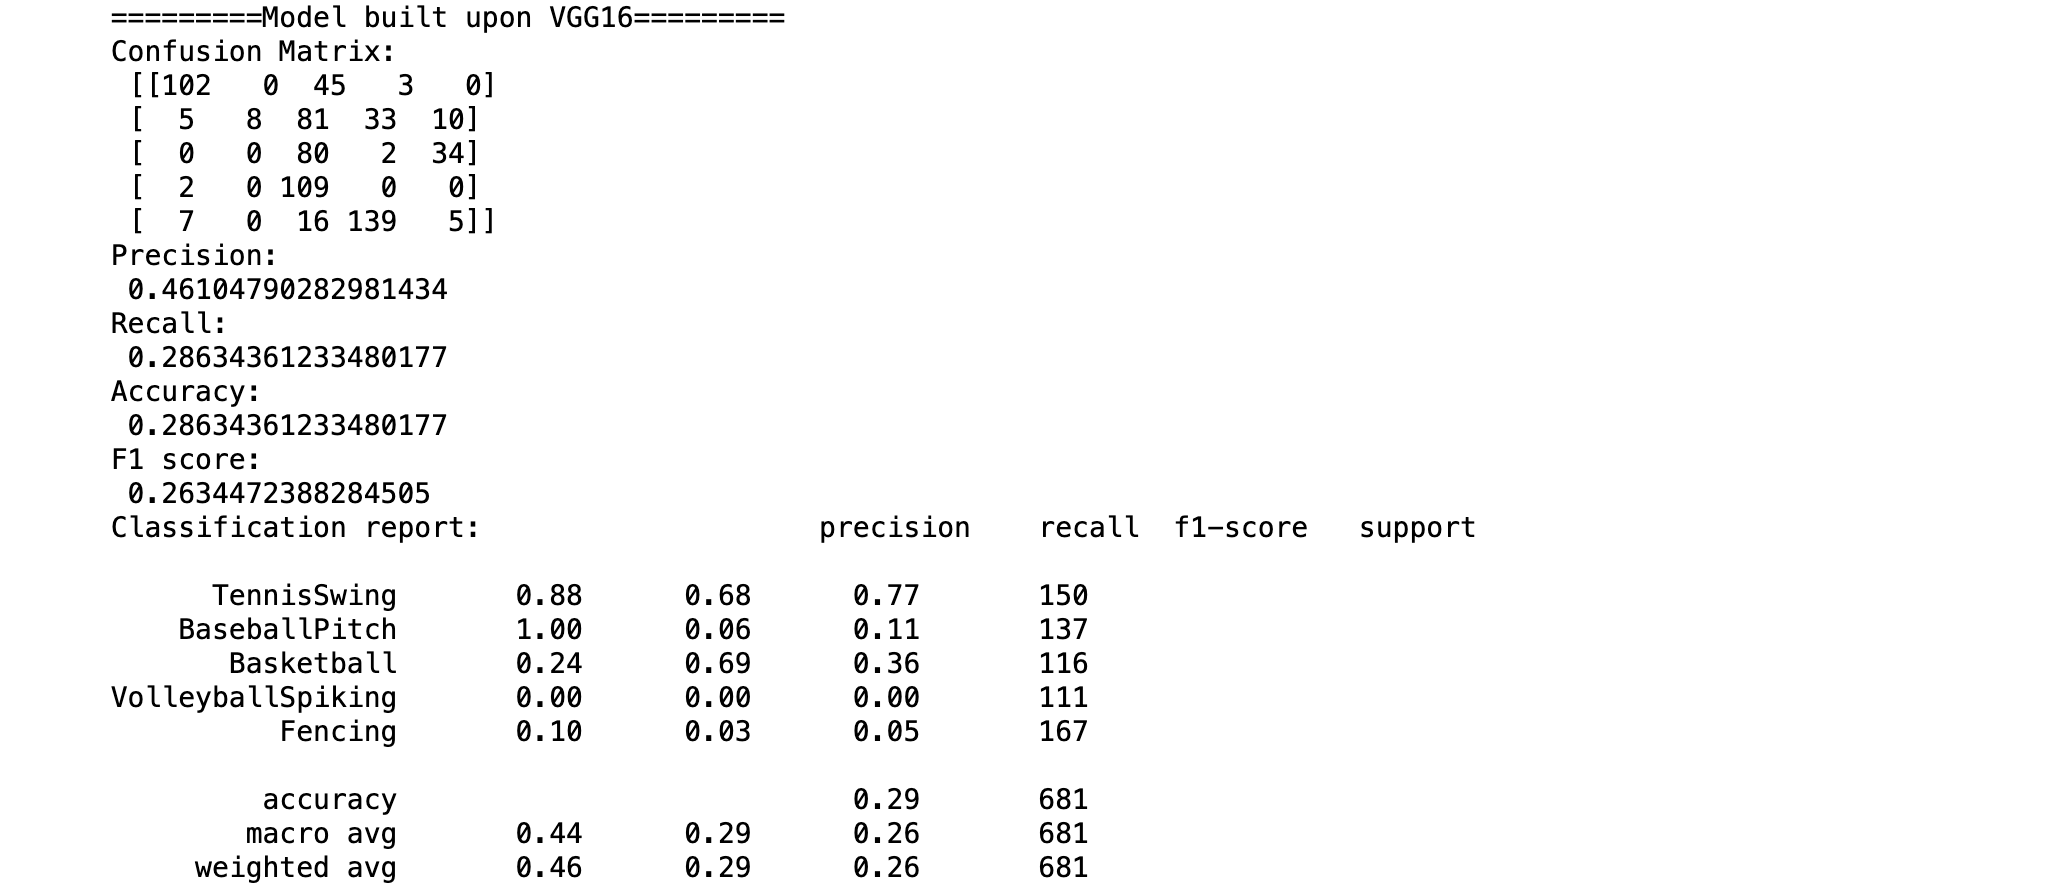